# Project ADA Final notebook

**Importing libraries**

We mainly used `Pandas` in order to do exploratory analysis. For mathematical operations, and arrays, we used `NumPy`. For plotting we used `Matplotlib` and `Seaborn`, and also for the cleaning part with the country names, the packagings and the labels to translate, we used `PyCountry`, `gettext`, `translate` and `re`. We finally needed `Folium` and `json` for the map visualizations. We added a few more libraries during the image analysis: `requests`to download the images, `os` to read them locally. `imutils` and `time` were necessary in the tutorial we followed. `cv2` does a lot about image processing and we used `sklearn` for kmeans.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry as pc
import gettext as gt
import re
from translate import Translator
import folium
import json
import requests
import os
from imutils.object_detection import non_max_suppression
import time
import cv2
from sklearn.cluster import KMeans

## Loading and first exploration

**Loading the dataset**

In [2]:
DATA_FOLDER = 'data/'
MAPS_FOLDER = 'maps/'

In [3]:
df = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', sep="\t", encoding="utf-8", low_memory=False)

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see from here that there is a lot of information, and it seems that there is a lot of NaN values for certain columns.

More precisely, we can compute the number of columns in the dataframe:

In [5]:
print('Number of columns in the DataFrame:', df.columns.size)

Number of columns in the DataFrame: 173


There are many features, but we definitely won't work with all of them for the purpose of this project.

As we explore the dataset, we will only keep a few columns from all those we have at our disposal.

**NaN proportion for each column**

As mentioned earlier, it looks like there are many NaN values. Let's see that. Here we compute the proportion of NaN values for each columns, and only plot the columns that have less than 50% of NaNs.

Number of columns that have a proportion of NaN less than 50%:  30 / 173 columns.


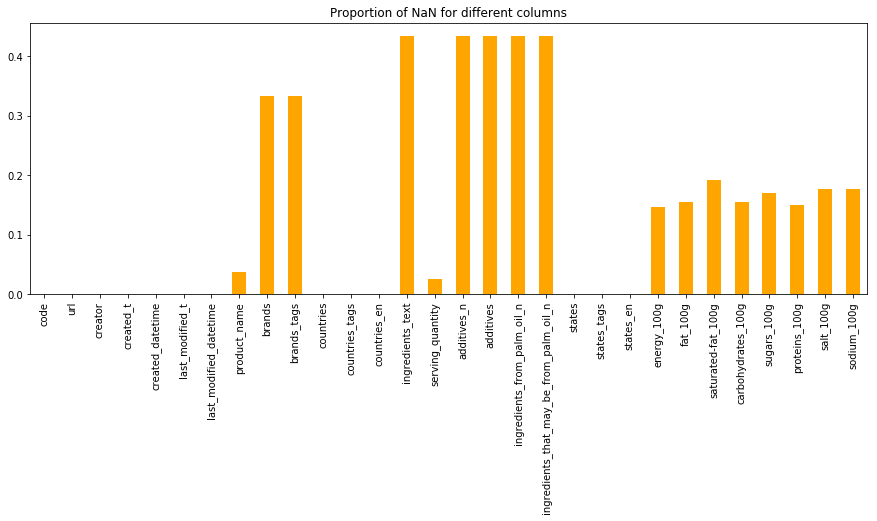

In [6]:
nan_proportion = df.isnull().mean(axis=0)
nan_proportion_50 = nan_proportion[nan_proportion<0.5]
print('Number of columns that have a proportion of NaN less than 50%: ', 
      nan_proportion_50.size, '/', df.columns.size, 'columns.')

plt.figure(figsize=(15, 5))
nan_proportion_50.plot(kind='bar', color='orange')
plt.title('Proportion of NaN for different columns')

plt.show()

Quite surprising! Actually, only 30 columns are more than half filled on the 173 that we have at our disposal. This suggest that maybe we will need to review some of things we planned to do because of the missing values. Indeed, if a huge amount of values are missing, we won't get very precise insights about the data for these columns.

**Choosing the columns to keep**

Now let's see with what columns we are going to work with. Of course, we keep the information about the products such as the name, brand, url. 

Then we also want to keep the information about the countries, since it was one of the main focus of the project.

We will also keep all those related to the composition of the products (serving quantity, additives, fat, sugar, ...) as it will help us get insights about which country eats what.

In [7]:
# Columns that we keep for the exploratory analysis
cols = ['product_name', 'url', 'code', 'brands_tags', 'countries_en', 'origins', 'serving_quantity', 'additives_n', 
        'fat_100g', 'carbohydrates_100g', 'sugars_100g', 
       'proteins_100g', 'salt_100g', 'labels', 'packaging']

# Filter to only keep the columns we need
df = df[cols]

## Cleaning the dataset

**Cleaning the countries columns**

The columns `origins` and `countries_en` need a lot of cleaning to be usable later.

In [8]:
# Put everything in lowercase in order to have more consistency
df['countries_en'] = df['countries_en'].str.lower() 
df['origins'] = df['origins'].str.lower()
df['packaging'] = df['packaging'].str.lower()
df['labels'] = df['labels'].str.lower()

For outlier exploration, we defined a function to check wether the columns with countries are in the right format or not.

In [9]:
def countries_format_check(df, column):
    """Counts the number of occurences of some unexpected 
    types or values for entries in the specified column
    """
    
    counter_wrong_type = 0
    counter_empty_string = 0
    counter_nan = 0

    for entry in df[column]:
        if not(type(entry) is str):
            counter_wrong_type += 1
        elif entry == "":
            counter_empty_string += 1
            
        if entry != entry: # entry is NaN <=> entry != entry
            counter_nan += 1

    print("%d values in " %counter_wrong_type + column + " are not of type 'str'")
    print("%d values in " %counter_nan + column + " are nan")
    print("%d values in " %counter_empty_string + column + " are empty strings")

In [10]:
countries_format_check(df, 'countries_en')

597 values in countries_en are not of type 'str'
597 values in countries_en are nan
0 values in countries_en are empty strings


As we can see, some entries in `countries_en` are actually not strings. Actually, these outliers are always NaN (so they have float type). Since this value is needed we can drop these samples.

In [11]:
countries_format_check(df, 'origins')

653706 values in origins are not of type 'str'
653706 values in origins are nan
0 values in origins are empty strings


In `origins`, it is even worse. We rarely even have anything else than a NaN. When we are interested in the origins of a product, we need to drop these outliers. Otherwise we need to keep them (or we would lose too much data).

**Exploding the countries columns**

In [12]:
def explode_dataframe(df, column, separator):
    """ Duplicates the rows of the input DataFrame df, by splitting on 'separator' the string contained in 'column'
        For example, when using this function on column C, with separator ',' on the following DataFrame
            A  B  C
        1   1  2  a,b
        2   3  4  c,d,e
    
        We expect a return value like this:
            A  B  C
        1   1  2  a
        1   1  2  b
        2   3  4  c
        2   3  4  d
        2   3  4  e
    """
    
    # Helper function that duplicates a single 'row' and appends the result to 'rows'
    def explode_row(row, rows):
        splitted_string = row[column].split(separator)
        for s in splitted_string:
            new_row = row.to_dict()
            new_row[column] = s
            rows.append(new_row)
    
    rows = []
    df.apply(lambda row : explode_row(row, rows), axis=1)

    new_df = pd.DataFrame(rows)
    return new_df

First, we split `countries_en` and `origins`, since they may contain more than one country.

In [13]:
df_with_countries = explode_dataframe(df.dropna(subset=['countries_en']), 'countries_en', ',')
print('New shape of our DataFrame:', df_with_countries.shape)

New shape of our DataFrame: (727877, 15)


As we can see, we end up with quite a lot more data when splitting to get all the countries separated.

In [14]:
df_with_origins = explode_dataframe(df_with_countries.dropna(subset=['origins']), 'origins', ',')
print('Shape of the DataFrame with the origins:', df_with_origins.shape)

Shape of the DataFrame with the origins: (62187, 15)


But due to the number of NaN values in `origins`, we have a lot less data in `df_with origins`. Now we'll either use `df_with_origins` when we need the origins and the countries where the products are sold, `df_with_countries` when we need only the country where the products are sold, and df when we do not need neither of them. Thus we can drop `origins` and `countries_en` in `df`, and `origins` in `df_with_countries`

In [15]:
df_with_countries = df_with_countries.drop(['origins'], axis=1)
df = df.drop(['countries_en', 'origins'], axis=1)

**Formatting the countries columns**

Now the main issue is that the format of these strings is not consistent at all. Some country names are written in french, some are in english, etc... Even in `countries_en` (where everything is supposed to be written in english, some entries are in french or in some other language, or even some kind of code). In `origins` it's even more frequently in some other language than english. Also some are very specific (country + region + county for example), and we will not be interested in so much spatial detail. We also still have outliers from which we cannot retrieve the country it corresponds to (like strings that do not even contain any spatial information).

First we load the main used languages that we will translate from. That choice is based on a previous result where we have got an idea of the countries of the products. We then have chosen the 12 top languages in those results. English is not in the list because we will translate from it.

In [16]:
languages = ['french', 'german', 'spanish', 'italian', 'dutch', 'russian', 'swedish',
             'portuguese', 'danish', 'romanian', 'hungarian']

We then use `gettext` to load the country names translations that are within `PyCountry`.

In [17]:
country_translations = []
for language in languages:
    country_translations.append(gt.translation('iso3166', pc.LOCALES_DIR, languages=[language]))

Now we need to be able to read the countries lists from PyCountry. We defined 4 functions for that.

In [18]:
# Read the country names in english
def read_country_names_en(lowercase=True):
    country_names = []
    for country in pc.countries:
        if lowercase:
            country_names.append(country.name.lower())
        else:
            country_names.append(country.name)
    return country_names

# Read the country names translated in another language
def read_country_names_translated(language):
    country_names = []
    for country in pc.countries:
        country_names.append(language.gettext(country.name).lower())
    return country_names

# Read the country alpha2 codes
def read_country_alpha2s():
    country_names = []
    for country in pc.countries:
        country_names.append(country.alpha_2.lower())
    return country_names

# Read the country alpha3 codes
def read_country_alpha3s():
    country_names = []
    for country in pc.countries:
        country_names.append(country.alpha_3.lower())
    return country_names

Now we can apply that to get a dictionary to translate the different country names or codes into the alpha3 code of the country (useful later to match the geo.json file when using Folium). We will also want to have the English name of the country, but that it will be trivial to translate from the alpha3 to the english name. We also manually defined a dictionary for the strings with the most occurences that the other dictionaries could not translate (like regions of some countries, or country codes that are not the actual alpha2 code of the country it is supposed to represent).

In [19]:
# Transform a list of keys and a list of values to a dictionary and add it to the dictionary list
def append_dict(dicts_list, keys_list, values_list):
    dicts_list.append(dict(zip(keys_list, values_list)))

# Concats all the dictionaries to one single dictionary
def concat_dicts(dicts_list):
    total_dict = {}
    for i in range(0, len(dicts_list)):
        total_dict = {**total_dict, **dicts_list[i]}
    return total_dict

In [20]:
country_names_dicts = []
countries_en = read_country_names_en() 
countries_a3 = read_country_alpha3s() # Values to which the names will map (alpha3 codes of the country names)

append_dict(country_names_dicts, countries_en, countries_a3)
for translation in country_translations:
    append_dict(country_names_dicts, read_country_names_translated(translation), countries_a3)
append_dict(country_names_dicts, read_country_alpha2s(), countries_a3)
append_dict(country_names_dicts, read_country_alpha3s(), countries_a3)

manual_dict = {
'en' : 'gbr',
'uk' : 'gbr',
'czech republic' : 'cze',
'south korea' : 'kor',
'eua' : 'usa',
'e.u.a.' : 'usa',
'palestine' : 'psx',
'syria' : 'syr',
'bretagne' : 'fra',
'normandie' : 'fra',
'sud-ouest' : 'fra',
'lait origine france' : 'fra',
'ecosse' : 'gbr',
'provence' : 'fra',
'equateur' : 'ecu',
'thailande' : 'tha',
'sud-ouest de la france' : 'fra',
'république dominicaine' : 'dom',
'ciudad de méxico' : 'mex',
'sicile' : 'ita',
'écosse' : 'gbr',
'camargue' : 'fra',
'bourgogne' : 'fra',
'corse' : 'fra',
'alsace' : 'fra',
' españa' : 'esp',
'bolivie' : 'bol',
'porc origine france' : 'fra',
'fr:lait de france' : 'fra',
'pays de la loire' : 'fra',
'aquitaine' : 'fra',
'québec' : 'can',
'ardèche' : 'fra',
'andalucía' : 'esp',
'agriculture france' : 'fra',
'angleterre' : 'gbr',
'ile de la réunion' : 'fra',
'etats-unis' : 'usa',
'val de loire' : 'fra',
'rhône-alpes' : 'fra',
'aveyron' : 'fra',
'auvergne' : 'fra',
'california' : 'usa',
'franche-comté' : 'fra',
'savoie' : 'fra',
'russie' : 'rus',
'alaska' : 'usa',
'fr:deutschland' : 'deu',
'ch:suisse' : 'che',
'loire-atlantique' : 'fra',
'de:allemagne' : 'deu',
'fr:schweiz' : 'che',
'fr:frankreich' : 'fra',
'republic of macedonia' : 'mkd',
'fr:quebec' : 'can',
'fr:dom-tom' : 'fra',
'democratic republic of the congo' : 'cog',
'republic of the congo' : 'cog'}

country_names_dicts.append(manual_dict)
countries_dictionary = concat_dicts(country_names_dicts)

We also define a dictionary from proper alpha3 code to English name. We keep the case because these names may appear on some plot so they need to look nice!

In [21]:
a3_to_en_dict = dict(zip(countries_a3, read_country_names_en(lowercase=False)))

We can now easily define an efficient function that translates a name with a dictionary.

In [22]:
# Translate the parameter 'word' to its corresponding value in the dictionary, or NaN if it is not found in the dictionary.
def translate(word, dictionary):
    return dictionary.get(word, np.NaN)

# Translate a whole column of a DataFrame with a dictionary.
def translate_column(df, column, to_column, dictionary):
    # Translate every word in the column
    df[to_column] = df[column].map(lambda word : translate(word, dictionary))
    # Get rid of the new NaN values induced by impossibility to translate
    df = df.dropna(subset=[to_column])
    return df

For example, when used on 'allemagne' and 'deu' with the other dictionary, we get:

In [23]:
print("Alpha-3 code of 'allemagne': " + translate('allemagne', countries_dictionary))
print("Country (in english) corresponding to the code 'deu': " + translate('deu', a3_to_en_dict))

Alpha-3 code of 'allemagne': deu
Country (in english) corresponding to the code 'deu': Germany


In [24]:
# Translate the 'countries_en' column in df
df_with_countries = translate_column(df_with_countries, 'countries_en', 'countries_a3', countries_dictionary)
df_with_countries = translate_column(df_with_countries, 'countries_a3', 'countries_en', a3_to_en_dict)

# Translate the 'countries_en' and the 'origins' columns in df_with_origins
df_with_origins = translate_column(df_with_origins, 'countries_en', 'countries_a3', countries_dictionary)
df_with_origins = translate_column(df_with_origins, 'countries_a3', 'countries_en', a3_to_en_dict)
df_with_origins = translate_column(df_with_origins, 'origins', 'origins_a3', countries_dictionary)
df_with_origins = translate_column(df_with_origins, 'origins_a3', 'origins', a3_to_en_dict)

In [25]:
print('Shape of our DataFrame with the countries:', df_with_countries.shape)
print('Shape of the DataFrame with the origins:', df_with_origins.shape)

Shape of our DataFrame with the countries: (727212, 15)
Shape of the DataFrame with the origins: (40665, 17)


As we can see, a few rows were lost in `df_with_countries` (~600 out of ~728k), but many were lost in `df_with_origins` (~22k out of ~62k) because the format of `origins` is very inconsistent.

**Packaging and Labels columns formatting**

For the `packaging` and `labels` columns, it's even more complicated.
Imagine if a product has packaging `plastic, bag`. Then exploding the packaging would result in two different rows, one with packaging `plastic`, the other with packaging `bag`. Since we want to make statistics on the packagings, this would give erroneous proportion for each of them.

For the country-related columns, it was not an issue because we are not interested in the proportion of products produced in each country, but we would rather want to make statistics on other interesting information for each country.

Our decision is to define different accessors to get each interesting label and each interesting packaging type in the dataset. With this approach we will avoid the problem stated above. The results will still be slightly biased, because we only consider those written in one of the top languages. We will not give any country-specific result for the countries that do not have enough datapoints, so this bias will be very small.

First we define a function that returns a boolean mask for a dataframe, computed from wether or not the input string is contained in each row (in the specified column).

In [26]:
def contains_str(df, column, string):
    return df[column].str.contains(string, na=False, flags=re.IGNORECASE)

Now we can use this function to define a higher level one, that returns all the elements of the input dataframe such that at a specified column, at least one of the `included_strings` parameter is contained, and none of the `excluded_strings` parameter is contained.

In [27]:
def filter_str_column(df, column, included_strings, excluded_strings=[]):
    df = df.reset_index(drop=True)
    boolean_mask = pd.Series(np.full((len(df)), False, dtype=bool))
    for string in included_strings:
        boolean_mask = boolean_mask | contains_str(df, column, string)
    for string in excluded_strings:
        boolean_mask = boolean_mask & ~contains_str(df, column, string)
    return df[boolean_mask]

We also defined a function to translate a word to a list of translations in the input languages. This was used to quickly make translations for the labels and packagings that we are interested into, but since it is API-based (and thus slow) we hard-coded the translations (so `multi_translate` is not used anymore). We also simplified them sometimes since we only need the string to be included (so a prefix works as well).

In [28]:
def multi_translate(word, languages):
    translations = []
    for language in languages:
        translator = Translator(to_lang=language)
        translations.append(translator.translate(word))
        
    return translations

The final keywords are here:

In [29]:
# Usual words or prefixes for organic products
# The regex \\bAB\\b is to find the acronym AB alone (a popular organic label in France)
organic_included = ['bio', 'organi', 'orgáni', 'Økologisk', 'szerves', '\\bAB\\b']

# Most of the gluten free products contain the word 'gluten' in their labels, or 'glutine' in Italian
# 1 product is labeled "avec gluten" so we have to get rid of it
gluten_free_included = ['gluten', 'glutine', 'клейковина', 'glúten', 'sikér']
gluten_free_excluded = ['avec gluten', 'mit gluten', 'con gluten', 'con glutine',
    'met gluten', 'с глютеном', 'med gluten', 'com glúten', 'cu gluten', 'a glutén']

# Most popular ways of writing the vegan label
# Some products are labeled "no vegan" so we have to get rid of them
vegan_included = ['vega', 'végétalien', 'vegetalien', 'végane']
vegan_excluded = ['no vegan']

# Containing 'halal' is necessary and sufficient for a product to be halal
halal_included = ['halal', 'xаляльное', 'helal']

# Fair trade is written down in different ways in the dataframe, so we have to gather most of them
fair_trade_included = ['commerce équitable', 'fairtrade', 'fair trade', 'fair-trade', 'commercio equo e solidale', 
    'eerlijke handel', 'честная торговля', 'feira comercial', 'comerț echitabil', 'tisztességes üzlet']

# Usual words or prefixes for plastic in the most used languages
plastic_included = ['plast', 'kunststof', 'plástico', 'пластик', 'műanyag']

# Usual words or prefixes for cardboard or paper in the most used languages
cardboard_included = ['cart', 'cardboard', 'karton', 'Картон', 'pap', 'бумага', 'hârtie']

# Usual words or prefixes for glass in the most used languages
glass_included = ['verre', 'glas', 'vidrio', 'стекло', 'sticlă', 'pohár']

# Usual words or prefixes for metal or aluminium in the most used languages
metal_included = ['metal', 'métal', 'металл', 'fém', 'alumini', 'alumíni', 'алюминий', 'can']

With all of that, we can super easily define functions to get all the elements of the dataframe that match what we are interested into. Most of the times we only need to include the translations of the info we want to have, but sometimes we also have to specifically exclude some results. The values of `vegan_excluded` and `gluten_free_excluded` explain this very well.

In [30]:
def organic_label(df):
    return filter_str_column(df, 'labels', organic_included)

def no_organic_label(df):
    return filter_str_column(df, 'labels', [''], organic_included)

def vegan_label(df):
    return filter_str_column(df, 'labels', vegan_included, vegan_excluded)

def gluten_free_label(df):
    return filter_str_column(df, 'labels', gluten_free_included, gluten_free_excluded)

def halal_label(df):
    return filter_str_column(df, 'labels', halal_included)

def fair_trade_label(df):
    return filter_str_column(df, 'labels', fair_trade_included)

def plastic_packaging(df):
    return filter_str_column(df, 'packaging', plastic_included)

def cardboard_packaging(df):
    return filter_str_column(df, 'packaging', cardboard_included)

def glass_packaging(df):
    return filter_str_column(df, 'packaging', glass_included)

def metal_packaging(df):
    return filter_str_column(df, 'packaging', metal_included)

## Exploratory Analysis

Note that this section has not really been changed since milestone 2. Some of the analysis contained avoidable bias, and we decided to have a different approach in the later sections of the notebook (Stats per country). We have left some parts of the code that is still relevant (import - export) and we have removed what was not interesting anymore.

**Import - Export**

As a first analysis, we will try to visualize which countries import and export, for the main countries in the dataset.

Now let's get the destination and origin countries for the products, and try to first visualize which are the top destination countries:

In [31]:
dest_count = df_with_countries['countries_en'].value_counts()

We plot below the top-25 destination countries. Note that since France has a significantly higher number of products (this is a french dataset), we also plot in the log scale.

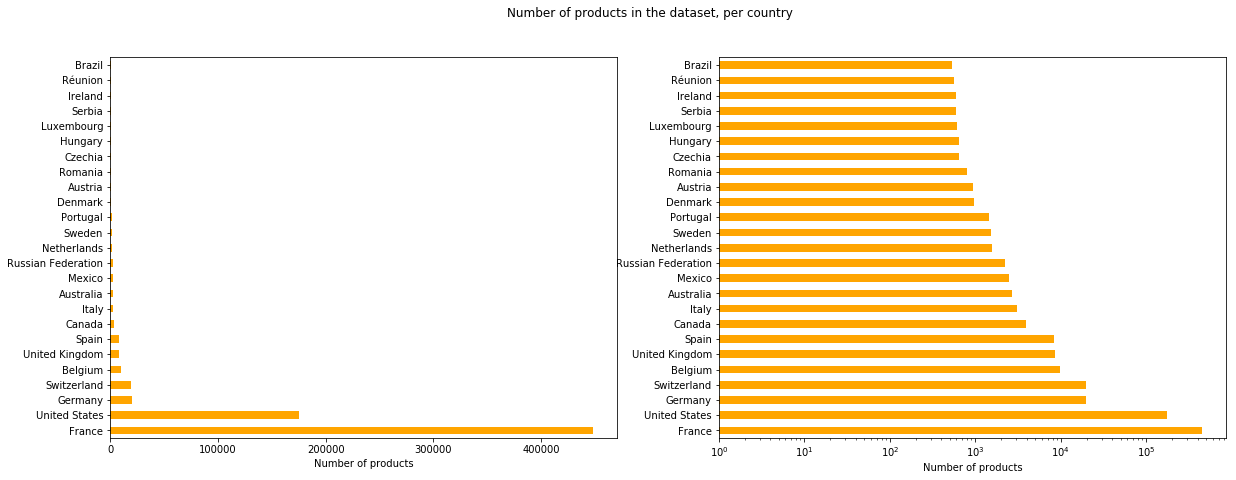

In [32]:
#Create subplots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

#Plot the count of the products for each destination country
dest_count[:25].plot(kind='barh', color='orange', ax=ax1)
ax1.set_xlabel('Number of products')

#Plot again in log scale
dest_count[:25].plot(kind='barh', color='orange', ax=ax2, log=True)
ax2.set_xlabel('Number of products')

f.suptitle('Number of products in the dataset, per country')
plt.show()

Not surprinsingly, the top countries are mainly those from Europe (again, the dataset focuses a lot on France and Europe), but we can also see the US, Canada and Mexico for example.

***We decided to focus our analysis on the countries that have the most products in their inventory, so that we can do the analysis on countries that have the most data points.***

So we will keep those top countries, and we will do the analyses on the first 15 of them. This will also help for the current visualizations that are mostly in bar charts (impossible to read if there are too many countries).


In [33]:
top_15 = df_with_origins['countries_en'].value_counts()[:15].index

Here, we will visualize the origins and destinations, for the top 15 countries in the destinations. We chose to represent this information as a heatmap. 
For each pair of countries, we compute the number of food products for that pair and add one to the corresponding cell in a matrix representing those pairs.

After the matrix is filled with the counts of the different pairs, we use the `heatmap()` function of Seaborn to visualize the results.

In [34]:
def compute_heatmap(df, countries):
    """Given a dataframe, compute a 
    heatmap matrix for import-export
    analysis of the given countries"""
    
    # Create the matrix that will contain the counts
    matrix = pd.DataFrame(np.zeros((countries.size, countries.size)), index=countries, columns=countries)

    # Fill in the matrix (for the top countries)
    for idx, row in df.iterrows():
        origin = row['origins']
        destination = row['countries_en']
        if destination in countries and origin in countries:
            matrix.at[origin, destination] += 1
    return matrix

In [35]:
def plot_heatmap(matrix):
    """Plot the given matrix as a heatmap"""
    
    # Create subplots
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Use Seaborn to plot a heatmap using the matrix
    sns.heatmap(matrix, linewidth=0.5, cmap='Reds', ax=ax1)
    ax1.set_ylabel('Origin Country')
    ax1.set_xlabel('Destination Country')

    # Plot again in log scale
    sns.heatmap(np.log(matrix+1), linewidth=0.5, cmap='Reds', ax=ax2)
    ax2.set_ylabel('Origin Country')
    ax2.set_xlabel('Destination Country')

    f.suptitle('Import-Export count between countries')
    plt.show()

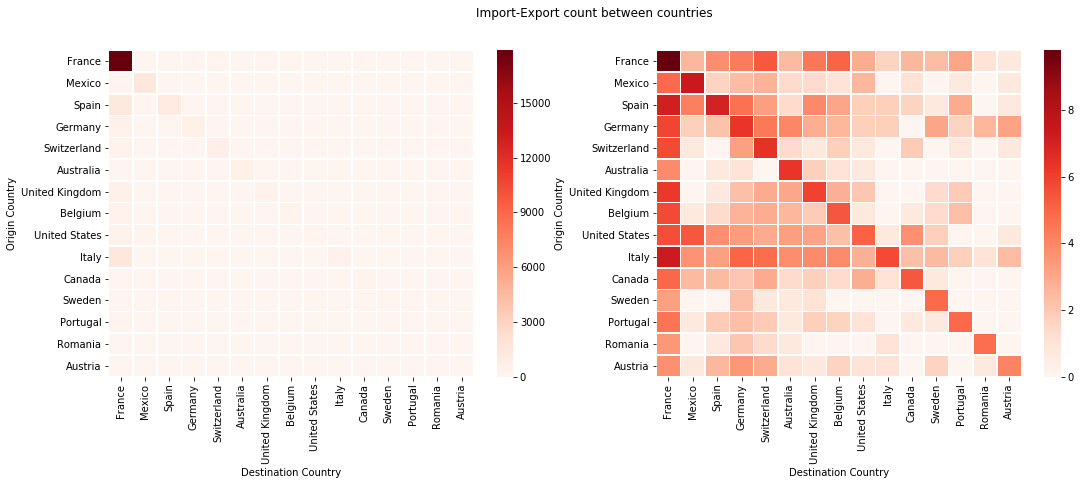

In [36]:
plot_heatmap(compute_heatmap(df_with_origins, top_15))

As France has a count that is a lot larger, we also plotted on the right with a log scale to get better insights. What we see from this plot is very interesting. 

With this dataset, it looks like many countries actually produce their own food (look at the diagonal). Again, as France has always more data in this dataset, we see that France import and export to many countries. This may definitely be biased, and that's why we prefer to focus also on the other countries.

Spain, Mexico, Australia and UK also produce a lot of their own food. As big exporters, we spot Spain, Germany, Italy, which makes sense for Europe, and we have the US for the American countries. As importers, the plot suggests that Germany, Switzerland, Australia and UK are the main ones.

## Stats per country

In this section we compute multiple dataframes containing stats for each country, in order to compare the countries. **These dataframes will be visualized in the maps of the next section.**

**Nutrition facts**

We are interested in various nutrition facts and we want to compare some food compositions between countries.

In [37]:
composition_cols = ['additives_n', 'fat_100g', 'carbohydrates_100g', 'sugars_100g', 'proteins_100g', 'salt_100g']

First we define a function to drop the 'obvious' outliers. That is: if a value is supposed to be in an interval, drop any value that is not in this interval.

In [38]:
def drop_outliers(df, column, min_value, max_value):
    df = df.dropna(subset=[column])
    df = df[(df[column] <= max_value) & (df[column] >= min_value)]
    return df

Now we can define a function that computes the stats per country for a given column (for example `fat_100g`)

In [39]:
def compute_stats_per_country(df, column, min_value, max_value):
    df = drop_outliers(df, column, min_value, max_value)
    df_stats = df[['countries_a3', column]].groupby('countries_a3').describe()
    return df_stats

We'll also need a function to drop the nan values and keep only the countries with enough data samples:

In [40]:
def format_for_choropleth(df, column, min_count=0):
    df = df[column].reset_index().dropna(subset=['mean'])
    if min_count <= 0:
        return df
    else:
        return df[df['count'] >= min_count]

We compute the stats for each food composition category and store that in a single dataframe `df_nutrition`.

In [41]:
frames = []
for col in composition_cols:
    frames.append(compute_stats_per_country(df_with_countries, col, 0, 100))

df_nutrition = pd.concat(frames, axis=1, sort=True)
df_nutrition.index = df_nutrition.index.map(lambda a3 : a3.upper())

**Packaging and labels**

Recall the packagings and the labels of interest.

In [42]:
packagings_of_interest = ['plastic', 'cardboard', 'glass', 'metal']
labels_of_interest = ['organic', 'vegan', 'gluten_free', 'halal', 'fair_trade']

We have defined a function to compute the proportion of products with a specified packaging or label, for a specified country. It also returns the number of products with non-nan entry for the corresponding column (`labels` or `packaging`) so that later on we do not display countries with not enough data samples.

In [43]:
def proportion(df, category, kind): # Result is a count and a percentage
    total_size = df.size
    
    df = df.dropna(subset=[category])
    
    # In case we are looking at the packaging we only need to divide by the size without the nan values
    if category == 'packaging':
        total_size = df.size
    
    if kind == 'plastic':
        quantity = plastic_packaging(df).size
    elif kind == 'cardboard':
        quantity = cardboard_packaging(df).size
    elif kind == 'glass':
        quantity = glass_packaging(df).size
    elif kind == 'metal':
        quantity = metal_packaging(df).size
    elif kind == 'organic':
        quantity = organic_label(df).size
    elif kind == 'vegan':
        quantity = vegan_label(df).size
    elif kind == 'gluten_free':
        quantity = gluten_free_label(df).size
    elif kind == 'halal':
        quantity = halal_label(df).size
    elif kind == 'fair_trade':
        quantity = fair_trade_label(df).size
        
    return total_size, (quantity * 100 / total_size)

Now we define a function to compute the proportion of something per country.

In [44]:
keys = np.unique(df_with_countries['countries_a3'].values)

def compute_proportion_per_country(df, kind, category):
    proportions = []
    for key in keys:
        df_country = df[df['countries_a3'] == key]
        proportions.append(proportion(df_country, kind, category))
        
    columns = pd.MultiIndex(levels=[[category], ['count', 'mean']], labels=[[0, 0], [0, 1]])
    return pd.DataFrame(proportions, keys, columns=columns)

We compute the proportions of each label and packaging of interest and store that in a single dataframe `df_proportions`.

In [45]:
frames = []
for packaging in packagings_of_interest:
    frames.append(compute_proportion_per_country(df_with_countries, 'packaging', packaging))
    
for label in labels_of_interest:
    frames.append(compute_proportion_per_country(df_with_countries, 'labels', label))

df_proportions = pd.concat(frames, axis=1, sort=True)
df_proportions.index = df_proportions.index.map(lambda a3 : a3.upper())

C:\Users\Matthieu\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in long_scalars


**Imports and exports**

We define a function to compute a dataframe with the import and export proportions for each country.

In [46]:
def compute_import_export(df, country):
    # Export count
    exporting_to = df[(df['origins'] == country) & ~(df['countries_en'] == country)]
    export_count = exporting_to.groupby('countries_a3').size()
    export_percentage = export_count * 100 / export_count.sum()
        
    # Import count
    importing_from = df[(df['countries_en'] == country) & ~(df['origins'] == country)]
    import_count = importing_from.groupby('origins_a3').size()
    import_percentage = import_count * 100 / import_count.sum()
    
    columns_export = pd.MultiIndex(levels=[['export'], ['mean']], labels=[[0], [0]])
    columns_import = pd.MultiIndex(levels=[['import'], ['mean']], labels=[[0], [0]])
    
    # Convert to dataframe, and set the alpha3 to uppercase
    df_export = pd.DataFrame(export_percentage, columns=columns_export)
    df_import = pd.DataFrame(import_percentage, columns=columns_import)
    
    df_export.index = df_export.index.map(lambda a3 : a3.upper())
    df_import.index = df_import.index.map(lambda a3 : a3.upper())
    
    
    frames = [df_export, df_import]
    df_import_export = pd.concat(frames, axis=1, sort=True)
    
    return df_import_export

As an example, we use it with France (the country with the most data samples).

In [147]:
df_import_export_fr = compute_import_export(df_with_origins, 'France')

This DataFrame is used in the map vizualizations.

C:\Users\Matthieu\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


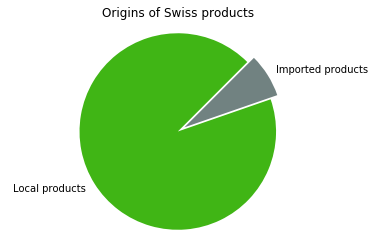

Importation ratio for Swiss products: 7.18%


In [167]:
imported_color = '#718281'
local_color = '#40b515'

local_swiss_products = len(df_with_origins[(df_with_origins['countries_en'] == 'Switzerland') & \
                                            (df_with_origins['origins'] == 'Switzerland')])

imported_swiss_products = len(df_with_countries[(df_with_countries['countries_en'] == 'Switzerland') & \
                                                 (df_with_origins['origins'] != 'Switzerland')])

plt.pie([local_swiss_products, imported_swiss_products], \
       labels=['Local products', 'Imported products'], \
       colors=[local_color, imported_color], \
       explode=(0, 0.08), startangle=45)
plt.title('Origins of Swiss products')
plt.axis('equal')
plt.show()

importation_ratio_switzerland = imported_swiss_products / (imported_swiss_products + local_swiss_products) * 100
print(f'Importation ratio for Swiss products: {importation_ratio_switzerland:.2f}%')

For this plot we had enough data so we decided to do it with Swiss products.

It represents the proportion of food that is produced is Switzerland to the total number of products that are sold in Switzerland. We can see that local products represents a big part of the chart so this is very good news as it means that food is not travelling too far before coming to Swiss consumers.

Note that what we call 'Local products' are made in Switzerland but this does not necessarly mean that they are made by a Swiss company.

## Map visualizations

Even if we do not have enough data to get meaningful stats on all countries, it will be good to visualize our results on a world map. Some countries will just be colored grey if they do not have enough data samples.

First we load the geo.json file that will allow us to color the countries.

In [48]:
geo_json_data = json.load(open(DATA_FOLDER + 'world_low.geo.json'))

europe_countries = folium.GeoJson(
    geo_json_data,
    name='geojson'
)

Then we define a function to draw a Folium choropleth on a map with a Multi-index dataframe of the form of `df_nutrition` and `df_proportions`.

In [49]:
# Draw the choropleth

def draw_choropleth(df, column, min_count, title, color='OrRd', nan_opacity=1, nan_color='#afafaf'):
    m = folium.Map(
        location=[46.8, 8.2],
        tiles='cartodbpositron',
        zoom_start=2
    )

    m.choropleth(geo_data=geo_json_data,
        data=format_for_choropleth(df, column, min_count), 
        name=title,
        columns=['index', 'mean'], key_on='feature.properties.adm0_a3',
        fill_color=color, fill_opacity=0.5, line_opacity=0.2,
        nan_fill_opacity=nan_opacity,
        nan_fill_color=nan_color,
        legend_name=title
    )
    
    return m

Now we can draw the maps with every different food composition information on them.

In [50]:
m = draw_choropleth(df_nutrition, 'additives_n', 100, 'Average number of additives in the food products')
m.save(MAPS_FOLDER + 'world_additives.html')
display(m)

draw_choropleth(df_nutrition, 'fat_100g', 100, 'Average proportion of fat in the food products (%)').save(MAPS_FOLDER + 'world_fat.html')
draw_choropleth(df_nutrition, 'sugars_100g', 100, 'Average proportion of sugars in the food products (%)').save(MAPS_FOLDER + 'world_sugars.html')
draw_choropleth(df_nutrition, 'carbohydrates_100g', 100, 'Average proportion of carbohydrates in the food products (%)').save(MAPS_FOLDER + 'world_carbohydrates.html')
draw_choropleth(df_nutrition, 'proteins_100g', 100, 'Average proportion of proteins in the food products (%)').save(MAPS_FOLDER + 'world_proteins.html')
draw_choropleth(df_nutrition, 'salt_100g', 100, 'Average proportion of salt in the food products (%)').save(MAPS_FOLDER + 'world_salt.html')

C:\Users\Matthieu\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Same here for the different packaging proportions and label proportions. Unfortunately some of them (especially 'Halal', 'Fair-trade', 'Vegan' and 'Gluten-free') are very subject to outliers, rendering the results almost unusable.

In [51]:
m = draw_choropleth(df_proportions, 'plastic', 100, 'Proportion of packagings containing plastic (%)', 'Blues')
m.save(MAPS_FOLDER + 'world_plastic.html')
display(m)

draw_choropleth(df_proportions, 'metal', 100, 'Proportion of packagings containing metal (%)', 'Reds').save(MAPS_FOLDER + 'world_metal.html')
draw_choropleth(df_proportions, 'glass', 100, 'Proportion of packagings containing glass (%)', 'Blues').save(MAPS_FOLDER + 'world_glass.html')
draw_choropleth(df_proportions, 'cardboard', 100, 'Proportion of packagings containing cardboard (%)', 'Oranges').save(MAPS_FOLDER + 'world_cardboard.html')
draw_choropleth(df_proportions, 'organic', 100, 'Proportion of organic products (%)', 'Greens').save(MAPS_FOLDER + 'world_organic.html')
draw_choropleth(df_proportions, 'halal', 100, 'Proportion of halal products (%)', 'Reds').save(MAPS_FOLDER + 'world_halal.html')
draw_choropleth(df_proportions, 'fair_trade', 100, 'Proportion of fair-trade products (%)', 'Greens').save(MAPS_FOLDER + 'world_fair_trade.html')
draw_choropleth(df_proportions, 'vegan', 100, 'Proportion of vegan products (%)', 'Greens').save(MAPS_FOLDER + 'world_vegan.html')
draw_choropleth(df_proportions, 'gluten_free', 100, 'Proportion of gluten-free products (%)', 'Oranges').save(MAPS_FOLDER + 'world_gluten_free.html')

C:\Users\Matthieu\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


We can also draw a map of the exports and imports of France. Note that 

In [88]:
m = draw_choropleth(df_import_export_fr, 'export', 0, 'Export destinations for France (%)', nan_opacity=0)
m.save(MAPS_FOLDER + 'france_exports.html')
display(m)

m = draw_choropleth(df_import_export_fr, 'import', 0, 'Import origins for France (%)', nan_opacity=0)
m.save(MAPS_FOLDER + 'france_imports.html')
display(m)

C:\Users\Matthieu\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


**Links of the most important maps (they should all be displayed above if you are running our notebook as HTML):**

[Average proportion of fat in the food products in the world](maps/world_fat.html)

[Proportion of packagings containing plastic in the world](maps/world_plastic.html)

[Exports of France](maps/france_exports.html)

[Imports of France](maps/france_imports.html)

**Links of all the other maps (still interesting for most of them):**

[Average number of additives in the food products in the world](maps/world_additives.html)

[Average proportion of carbohydrates in the food products in the world](maps/world_carbohydrates.html)

[Average proportion of proteins in the food products in the world](maps/world_proteins.html)

[Average proportion of salt in the food products in the world](maps/world_salt.html)

[Average proportion of sugars in the food products in the world](maps/world_sugars.html)

[Proportion of packagings containing cardboard in the world](maps/world_cardboard.html)

[Proportion of packagings containing glass in the world](maps/world_glass.html)

[Proportion of packagings containing metal in the world](maps/world_metal.html)

[Proportion of vegan food products in the world](maps/world_vegan.html)

[Proportion of organic food products in the world](maps/world_organic.html)

[Proportion of halal food products in the world](maps/world_halal.html)

[Proportion of fair-trade food products in the world](maps/world_fair_trade.html)

[Proportion of gluten-free food products in the world](maps/world_gluten_free.html)

## Packaging differences between organic and non-organic products

For this we will compute the proportion of each of the materials of interest in the packaging, conditioned on the organic criterion.

First we define a function to compute the 99.99% confidence interval. This function works only for binary categorical data.

In [53]:
def error_99_99(count, proportion):
    numerator = 3.891 * (count)*(1-proportion)*(proportion)
    denominator = (count-1) * np.sqrt(count)
    return numerator/denominator

Now we can compute the proportions, errors and count for all products with a label that are not organic.

In [54]:
no_organic_proportions = [0, 0, 0, 0]
no_organic_count, no_organic_proportions[0] = proportion(no_organic_label(df), 'packaging', 'plastic')
no_organic_proportions[1] = proportion(no_organic_label(df), 'packaging', 'cardboard')[1]
no_organic_proportions[2] = proportion(no_organic_label(df), 'packaging', 'glass')[1]
no_organic_proportions[3] = proportion(no_organic_label(df), 'packaging', 'metal')[1]

no_organic_errors = [error_99_99(no_organic_count, no_organic_proportions[i] / 100) * 100 for i in range(0, 4)]

Same for products that are organic.

In [55]:
organic_proportions = [0, 0, 0, 0]
organic_count, organic_proportions[0] = proportion(organic_label(df), 'packaging', 'plastic')
organic_proportions[1] = proportion(organic_label(df), 'packaging', 'cardboard')[1]
organic_proportions[2] = proportion(organic_label(df), 'packaging', 'glass')[1]
organic_proportions[3] = proportion(organic_label(df), 'packaging', 'metal')[1]

organic_errors = [error_99_99(organic_count, organic_proportions[i] / 100) * 100 for i in range(0, 4)]

We can now display the results as bar charts with confidence intervals.

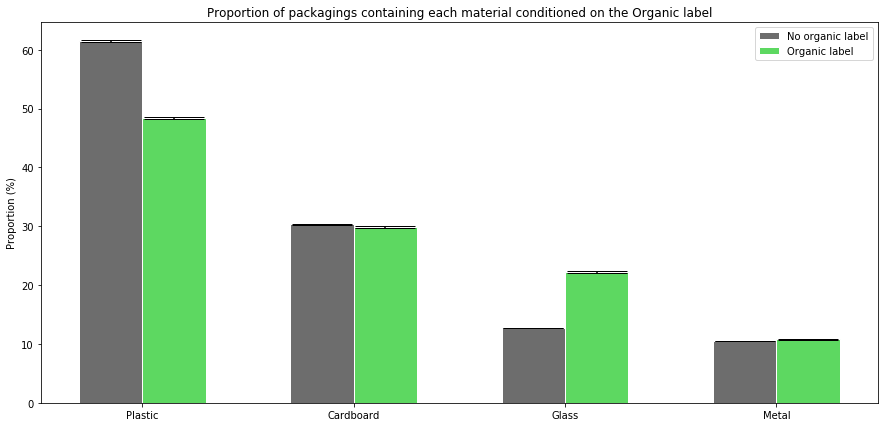

In [113]:
bar_width = 0.3
 
no_organic_pos = np.arange(4)
organic_pos = [x + bar_width for x in no_organic_pos]

no_organic_color = '#6d6d6d'
organic_color = '#5dd861'
edge_color = 'white'
capsize = 30

plt.figure(figsize=(15, 7))
 
# No-organic bars
plt.bar(no_organic_pos, no_organic_proportions, width=bar_width, color=no_organic_color, edgecolor=edge_color, yerr=no_organic_errors, capsize=capsize, label='No organic label')
 
# Organic bars
plt.bar(organic_pos, organic_proportions, width=bar_width, color=organic_color, edgecolor=edge_color, yerr=organic_errors, capsize=capsize, label='Organic label')

plt.xticks([r + bar_width/2 for r in range(4)], ['Plastic', 'Cardboard', 'Glass', 'Metal'])
plt.ylabel('Proportion (%)')
plt.title('Proportion of packagings containing each material conditioned on the Organic label')
plt.legend()
 
# Display
plt.show()

We can barely see the confidence interval, which is very good. That means we have enough data samples to be super confident about our results (remember that this is a 99.99% confidence interval). However, this is only true when assuming the datasets are unbiased, which is unfortunately not the case. We can still be pretty convinced that organic products tend to have different packagings than the average products (more glass and less plastic). This could be explained by a bias on the type of products that are more likely to be organic (fruits and vegetables for example) and at the same time less likely to be put in a plastic packaging (dual causality effect), or by marketing choices, or several other reasons we did not think of.
Note that the total does not sum to 100%. This is because some packagings contains multiple materials (cardboard and plastic for example) and some others contain no explicit description of the meterial (bottle, for example, could be a plastic or glass bottle, so we did not make any conclusion from non-explicit packaging materials).

## Images analysis

** Downloading images **

We had to go through another API to retrieve the images because the urls in the csv file were all wrong. The Open Food Fact database provides a JSON API which we used to get all the images url, and then downloading from the url to store images locally which was more convenient during our study.

In [57]:
# Retrieving front image url from barcode
def get_image_url(code):
    url = 'https://world.openfoodfacts.org/api/v0/product/' + str(code) + '.json'
    r = requests.get(url)
    json = r.json()
    if r.status_code == 200 and json['status_verbose'] == 'product found':
        try:
            return json['product']['image_url']
        except KeyError:
            try:
                return json['product']['selected_images']['front']['display']['fr']
            except KeyError:
                return 'No image available'
    else:
        return 'No image available'

In [58]:
# Saving image locally from url to a specific folder which needs to be created beforehand
def save_image(name, image_url, output_folder):
    image_data = requests.get(image_url).content
    file_name = name + '.jpg'
    with open(output_folder + file_name, 'wb') as handler:
        handler.write(image_data)

In [59]:
# Downloading n images (or all by default) from a df to an output folder
def download_images(df_to_download, output_folder, n=0):
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    i = 0
    if n > 0:
        barcodes = df_to_download.tail(n)['code']
    else:
        barcodes = df_to_download['code']
    
    length = len(barcodes)

    for code in barcodes:
        url = get_image_url(code)
    
        if url != 'No image available':
            save_image(code, url, output_folder)
            i = i + 1
    
        progress = str(i) + '/' + str(length)
        print(progress, end='\r')
    
    print('Download completed!')

In [60]:
n = 1000
print('Downloading', n, 'images corresponding to organic produts:')
download_images(organic_label(df), 'demo_bio/', n)
print('Downloading', n, 'images corresponding to non organic produts:')
download_images(no_organic_label(df), 'demo_non_bio/', n)

Download completed!
Download completed!


** Computing dominant colors in a collection of images **

This part is done in four steps:

1. Text detection to select the area on which to do the text detection (see reference)
2. KMeans for 2 colors on each image
3. Filtering of the results
4. KMeans for 50 colors on the filtered results

Essentially, we thought that looking for color on the whole images would not give us good results as many images had different backgrounds. Because we were only interested in the packages colors we had the idea to first do a text detection and then select only areas containing text. So we are doing this for all images and we extract two main colors: hopefully text and background. Then we convert these colors into HSV format to keep only those with high enough Saturation and Value (i.e. the more colorful ones). Finally, we extract 50 main colors to draw a spectrum of the dominant colors over the image collection.

_Text detection_

In [61]:
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
# Declare some constants used in the text detection functions
# A threshold to decide wheter an area contains text or not
DETECTION_CONFIDENCE = 0.5
# The dimension to which all images are resized during the detection
(SUB_IMAGE_H, SUB_IMAGE_W) = (320, 320)

In [62]:
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
# load the pre-trained EAST text detector
def load_network():
    return cv2.dnn.readNet('east_detector.pb')

In [63]:
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
# Detect text on an image, returns the likelihood for each area to contain text
def detect(net, image):
    # construct a blob from the image and then perform a forward pass of
    # the model to obtain the two output layer sets
    blob = cv2.dnn.blobFromImage(image, 1.0, (SUB_IMAGE_W, SUB_IMAGE_H), (123.68, 116.78, 103.94), swapRB=True, crop=False)
    net.setInput(blob)
    (scores, geometry) = net.forward(['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'])

    return (scores, geometry)

In [64]:
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
# This function is exactly the one used in the tutorial (cf reference)
def compute_rects_confidences(scores, geometry):
    
    numRows, numCols = scores.shape[2:4]
    rects = []
    confidences = []
 
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = scores[0, 0, y]
        xData0 = geometry[0, 0, y]
        xData1 = geometry[0, 1, y]
        xData2 = geometry[0, 2, y]
        xData3 = geometry[0, 3, y]
        anglesData = geometry[0, 4, y]

        for x in range(0, numCols):
            # Decides whether there is text or not
            if scoresData[x] < DETECTION_CONFIDENCE:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])
            
    return rects, confidences

In [65]:
# https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/
# Draw rectangular boxes around area containing text (for testing)
def draw_boxes(image, rects, confidences):
    # Select non overlapping boxes with high enough confidence
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    for (startX, startY, endX, endY) in boxes:
        # Rescale the boxes to the original image dimensions
        startX = int(startX / SUB_IMAGE_W * image.shape[1])
        startY = int(startY / SUB_IMAGE_H * image.shape[0])
        endX = int(endX / SUB_IMAGE_W * image.shape[1])
        endY = int(endY / SUB_IMAGE_H * image.shape[0])

        cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
    
    return image

In [66]:
# Demonstrate how text detection works on an image
def demo_text_detection(east_net):
    image = cv2.imread('demo/ketchup_bad_quality.jpg')
    copy = image.copy()
    scores, geometry = detect(east_net, image)
    rects, confidences = compute_rects_confidences(scores, geometry)
    image_with_detection = draw_boxes(copy, rects, confidences)
    plt.imshow(image_with_detection[..., ::-1])
    plt.axis('off')
    plt.title('Result of text detection')
    plt.show()

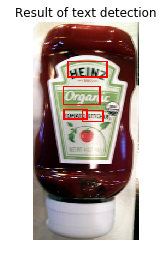

In [67]:
east_net = load_network()
demo_text_detection(east_net)

The red rectangle clearly show areas containing text. Now computing the dominant colors in these areas should give us a pretty good idea of the colors on the label.

_Computing dominant colors, 1st KMeans_

In [68]:
# Returns a list indicating whether or not a pixel has to be considered a feature
# This function is also inspired by the tutorial (cf reference)
# It does the same as 'draw_rect' but instead of drawing rectangles on the image, it select the pixels inside these
def extract_features(rects, confidences, features, rW, rH):
    # apply non-maxima suppression to suppress weak, overlapping bounding boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        startX = max(0, int(startX * rW))
        startY = max(0, int(startY * rH))
        endX = min(int(endX * rW), features.shape[1])
        endY = min(int(endY * rH), features.shape[0])
                        
        for x in range(startX, endX - 1):
            for y in range(startY, endY - 1):
                features[y, x] = True
                
    return features

In [69]:
# Creates a k x 3 array containing the k dominant colors in a given image
def get_dominant_colors(input_folder, filename, net, kmeans):
    
    image = cv2.imread(input_folder + filename)
    orig = image.copy()
    (H, W) = image.shape[:2]
    image = cv2.resize(image, (SUB_IMAGE_H, SUB_IMAGE_W))
    rW = W / float(SUB_IMAGE_W)
    rH = H / float(SUB_IMAGE_H)

    (scores, geometry) = detect(net, image)
    rects, confidences = compute_rects_confidences(scores, geometry)
    
    text_in_image = np.full((H, W), False)
    text_in_image = extract_features(rects, confidences, text_in_image, rW, rH)
    text_in_image = text_in_image.reshape((H * W))
    features = orig.reshape((H * W, 3))[text_in_image == True]
    
    dominant_colors = None
    if len(features) > 0:
        dominant_colors = kmeans.fit(features.astype(float)).cluster_centers_
    
    return dominant_colors

In [70]:
# Creates an image from a list of dominant colors
def create_dominant_image(dominants, width, height):
    nb_colors = len(dominants)
    height_per_color = height // nb_colors
    color_image = np.zeros((height_per_color * nb_colors, width, 3), np.uint8)
    
    for i in range(nb_colors):
        color = dominants[i]
        
        for y in range(height_per_color):
            color_image[y + height_per_color * i, :] = color

    return color_image

In [71]:
# Demonstrate the result of computing the k dominant colors on a single image
def demo_kmeans_on_image(east_net, k):
    kmeans = KMeans(k, random_state=0, n_init=4)
    dominants = get_dominant_colors('demo/', 'ketchup_bad_quality.jpg', east_net, kmeans)
    image_demo = create_dominant_image(dominants, 50, 300)
    plt.imshow(image_demo[..., ::-1])
    plt.axis('off')
    plt.title('Result of KMeans with k = ' + str(k))
    plt.show()

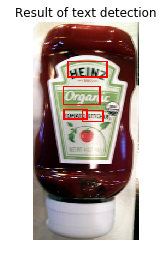

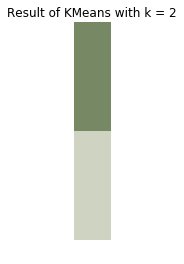

In [72]:
demo_text_detection(east_net)
demo_kmeans_on_image(east_net, k=2)

The KMeans algorithm was able to find two dominant colors on the label. This is a good example of how powerful our method is since it actually shows that the label is mainly green and white without taking into account the fact that the product is red. In the following, the white will also be discarded by the HSV filter and the remaining will be added to the list of colors on which to do the final KMeans.

_Computing dominant colors, HSV filter and 2nd KMeans_

In [73]:
# Filter an image and return only pixels with a high enough Value and Saturation
def hsv_filter(image, thresholdS=40, thresholdV=30):
    initial_shape = image.shape
    image = np.float32(image)    
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_image = hsv_image.reshape((initial_shape[0] * initial_shape[1], 3))
    
    image = image.reshape((initial_shape[0] * initial_shape[1], 3))

    filtered = image[(hsv_image[:, 1] > (thresholdS / 100)) & (hsv_image[:, 2] > (thresholdV * 255 / 100))]
    
    return filtered

In [74]:
# Order a list of colors by Hue in order to draw a good looking spectrum
def hsv_order_colors(colors):
    colors = np.float32(colors)
    colors = colors.reshape((1, len(colors), 3))
    hsv_colors = cv2.cvtColor(colors, cv2.COLOR_BGR2HSV)
    hsv_colors = hsv_colors.reshape((hsv_colors.shape[1], 3))
    
    # Sorting by Hue
    hsv_colors = hsv_colors[hsv_colors[:,0].argsort()[::-1]]
    return cv2.cvtColor(hsv_colors.reshape((1, len(hsv_colors), 3)), cv2.COLOR_HSV2BGR).reshape((len(hsv_colors), 3))
    

In [75]:
# Create a k x n x 3 array with the k dominant colors in n images
# If n = -1, it will take all images in folder
def get_dominants(input_folder, k, n=-1):
    j = 1
    empty_images = 0
    dominants = np.full((1, 3), 255)
    east_net = load_network()
    kmeans = KMeans(k, random_state=0, n_init=4)
    
    if n < 0:
        n = len([i for i in os.listdir(input_folder) if i.endswith('jpg')])

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            
            try:
                dominant_colors = get_dominant_colors(input_folder, filename, east_net, kmeans)

                if not dominant_colors is None:
                    dominants = np.append(dominants, dominant_colors, axis=0)
                else:    
                    empty_images += 1

            except SystemExit:
                raise
                
            # Catching a KeyboarkInterrupt exception allow us to stop the function anytime and still retrieve intermediary results
            except KeyboardInterrupt:
                dominants = np.delete(dominants, 0, axis=0)
                return dominants.reshape((len(dominants)//k, k, 3))
            
            # For other exceptions we just skip the current image and move to the next one
            except Exception as e:
                print(e)
                
            print(f'{j}/{n} ----> {empty_images} images with no text', end='\r')
            j = j + 1

        if j > n:
            break

    dominants = np.delete(dominants, 0, axis=0)
    return dominants.reshape((len(dominants)//k, k, 3))

In [76]:
# Draw a spectrum of dominant colors from all images in a folder
def demo_spectrum(input_folder, title, k_colors_per_image, k_colors_for_spectrum):
    dominants = get_dominants(input_folder, k=k_colors_per_image)
    filtered = hsv_filter(dominants)
    kmeans = KMeans(k_colors_for_spectrum, random_state=0)
    global_dominant = kmeans.fit(filtered).cluster_centers_
    global_dominant = hsv_order_colors(global_dominant)
    dominant_image = create_dominant_image(global_dominant, 50, 300)
    plt.imshow(dominant_image[...,::-1])
    plt.axis('off')
    plt.title(title)
    plt.show()

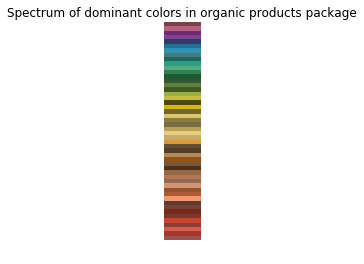

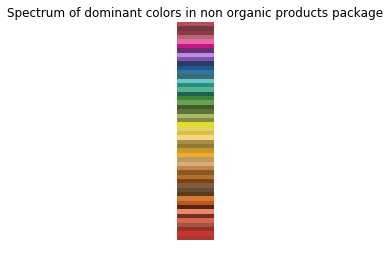

In [77]:
demo_spectrum('demo_bio/', 'Spectrum of dominant colors in organic products package', \
              k_colors_per_image=2, k_colors_for_spectrum=50)
demo_spectrum('demo_non_bio/', 'Spectrum of dominant colors in non organic products package', \
              k_colors_per_image=2, k_colors_for_spectrum=50)

As we can see, organic products appear to contain more green colors on their package. Brown is a also quite present and colors in general are gloomier.

*** Reference: ***

* OpenCV Text Detection (EAST text detector): https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/

We followed this tutorial in order to do our text detection since we couldn't find a library providing functions achieving the same results.

## Plans for the next steps of the project

**Plans for the presentation**

For the presentation, we plan to:

- Give an introduction about the problem of how the food travels, packaging issues and nutrition concerns.

- Explain what our project was about (where the food comes from, organic products, packaging & nutritional values)

- Show and explain the different insights we got together with the maps of the world

- Show the machine learning part and indicate the patterns and dominant colors we found for the organic products